In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json

In [3]:
'''
fips
election_type
total_districts
total_represenatives

ensemble summary
    average_seat_share
    average_vote_share


per plan (one out of 5k)
    opportunity_representatives
    opportunity_districts
    dem_vote_share
    rep_vote_share
    total_reprentatives


    demographics
        black
        white
        hispanic
        asian

'''

{}

In [249]:


def election_result_collection(data, json):

    planId = []
    democratsPercentage = []
    republicanPercentage = []
    i = len(json.get("ensembles", []))
    
    for item in data:
        
        elec_res = item.get("elec_res", {})

        totals_for_party = elec_res.get("percents_for_party", {})
        dem_totals = totals_for_party.get("Democratic", {})
        rep_totals = totals_for_party.get("Republican", {})

        avg_dem_share = []
        avg_rep_share = []

        for district_id in dem_totals:
            #total votes (dem and rep) from the same disctrict (inside the district plan)
            total_votes = dem_totals[district_id] + rep_totals.get(district_id, 0)

            if total_votes > 0:
                dem_percentage = dem_totals[district_id] / total_votes * 100
                rep_percentage = rep_totals.get(district_id, 0) / total_votes * 100
            else:
                dem_percentage = 0
                rep_percentage = 0

            avg_dem_share.append(dem_percentage)
            avg_rep_share.append(rep_percentage)


        i+=1
        planId.append(i)
        democratsPercentage.append(round(np.mean(avg_dem_share)/100, 2))
        republicanPercentage.append(round(np.mean(avg_rep_share)/100,2))
        
      
    ensembles = [ {"planId": v1, "democratsPercentage":v2, "republicanPercentage": v3  }
                for v1 ,v2, v3 in zip(planId, democratsPercentage, republicanPercentage)]
    json["ensembles"].extend(ensembles) 
def calculate_opportunity_SMD(data, json, minority='hispanic',opportunity_threshold=0.23):

    results = []

    for district_plan in data['ensembles']:
        plan_id = district_plan['planId']
        opportunity_districts = 0

        for district in district_plan['districts']:
            total_population = district['white'] + district['black'] + district['asian'] + district['hispanic']
            minoirty_population = district[minority]

            minority_proportion = minoirty_population / total_population

            if minority_proportion >= opportunity_threshold:
                opportunity_districts += 1

        for plan in json['ensembles']:
            if plan['planId'] == plan_id:
                plan['opportunityRepresentatives'] = opportunity_districts  # SMD: 1 rep per district
                plan['opportunityDistricts'] = opportunity_districts
                break
    return results
def collect_ensemble_demographic(data,shapefile ,json):
    i = len(json.get("ensembles", []))
    planId = []
    white = []
    black = []
    asian = []
    hispanic = []
    for item in data:
    
        districts =  item.get("ids", {})
        demo_summary= {
                    "white": 0,
                    "black": 0,
                    "asian": 0,
                    "hispanic": 0
            }
        for district_id, precinct_ids  in districts.items():
       
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row["HPAC"]
        i+=1
        planId.append(i)
        white.append(demo_summary["white"])
        black.append(demo_summary["black"])
        asian.append(demo_summary["asian"])
        hispanic.append(demo_summary["hispanic"])

    ensembles = [ {"planId": v1, "white":v2, "black": v3, "asian": v4, "hispanic": v5  }
                for v1 ,v2, v3, v4, v5 in zip(planId, white, black, asian, hispanic)]
    
    json["ensembles"].extend(ensembles)                 
def collect_district_plan_demographic(data, shapefile, json):
    i = len(json.get("ensembles", []))  # Start planId based on existing data

    for item in data:
        districts = item.get("ids", {})
        district_demographics = []

        for district_id, precinct_ids in districts.items():
            
            demo_summary = {
                "districtId": district_id,
                "white": 0,
                "black": 0,
                "asian": 0,
                "hispanic": 0
            }

            
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row["HPAC"]

          
            district_demographics.append(demo_summary)

        
        i += 1
        json["ensembles"].append({
            "planId": i,
            "districts": district_demographics
        })




In [256]:

shp_path = 'nv_2020_final/nv_2020_final.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['HPAC'] = shapefile['HPAC'].fillna(0)

with open('random_district0.json', 'r') as file:
    raw_data_district0 = json.load(file)
with open('random_district2.json', 'r') as file:
    raw_data_district2 = json.load(file)
with open('random_district4.json', 'r') as file:
    raw_data_district4 = json.load(file)

nv_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": "4",
    "avgVoteShare": 0,
    "avgSeatShare": 0,
    "ensembles": []

    }
nv_demographic_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": "4",
    "ensembles": []

    }


election_result_collection(raw_data_district0, nv_data)
election_result_collection(raw_data_district2, nv_data)
election_result_collection(raw_data_district4, nv_data)
collect_district_plan_demographic(raw_data_district0,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district2,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district4,shapefile ,nv_demographic_data)
calculate_opportunity_SMD(nv_demographic_data, nv_data, 'black', 0.23)
nv_data
file_path = 'nv_ensemble_bar.json'
with open(file_path, 'w') as json_file:
    json.dump(nv_data, json_file, indent=4)



In [207]:
def party_split_bar_plot(data, title, x_label, y_label):
    
    diff_values = [ (d["democratsPercentage"]- d["republicanPercentage"]) * 10 for d in data["ensembles"]]

    bins = [i / 100 for i in range(101)] 
    plt.figure(figsize=(10, 6))
    plt.hist([val for val in diff_values if val < 0],bins=5, color='#FF0000', alpha=0.7, label="Below 50% (REP)")
    plt.hist([val for val in diff_values if val >= 0],bins=5, color='#0015bc', alpha=0.7, label="Above 50% (DEM)")
    #seat_share = f"Average Seat Share: {data['average_seat_share'] * 100}%"
    #vote_share = f"Vote Share: {data['vote_share'] * 100}%"
    #plt.gcf().text(0.65, 0.8, f"{seat_share}\n{vote_share}", fontsize=10,
    #               bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.xlim(-0.7, 0.7)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

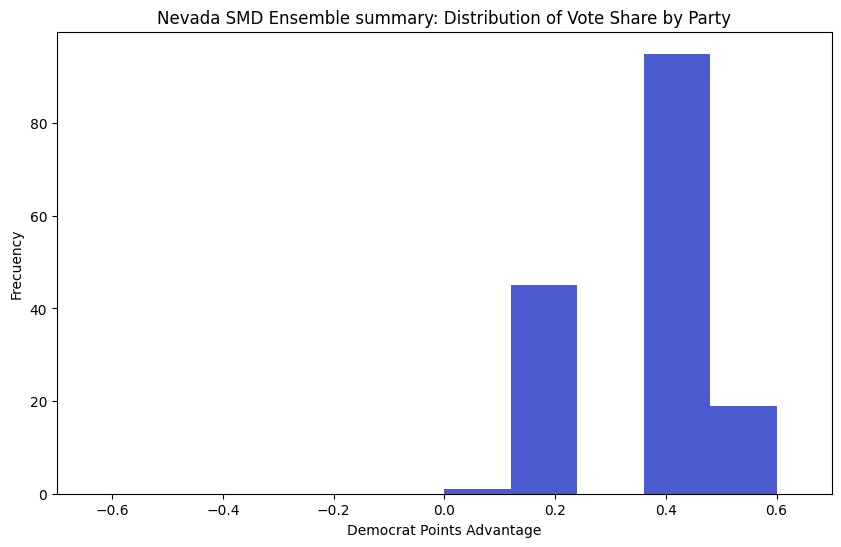

In [208]:
party_split_bar_plot(election_data, "Nevada SMD Ensemble summary: Distribution of Vote Share by Party", "Democrat Points Advantage", "Frecuency")

# link nevada data set with populated data

In [210]:
shp_path = 'nv_2020_final/nv_2020_final.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile



,STATEFP,COUNTYFP,COUNTY,VTDST,NAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREIBLA,G20PREONON,...,RACPOP_SUM,SCALING_FA,WHT,AFAM,AIAN,ASN,HPAC,OTHR,LAT,geometry
0,32,31,Washoe,007549,7549,0,1,0,0,0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-120.00103 39.57869 0, -120.00148 ..."
1,32,31,Washoe,008110,8110,160,136,3,1,1,...,357.0,0.963585,286.0,3.0,11.0,12.0,1.0,9.0,23.0,"POLYGON Z ((-120.0057 39.22977 0, -120.00569 3..."
2,32,31,Washoe,005065,5065,0,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-120.0023 39.49552 0, -119.9979 39..."
3,32,31,Washoe,005053,5053,6,20,0,0,1,...,60.0,0.916667,37.0,0.0,2.0,4.0,0.0,4.0,9.0,"POLYGON Z ((-119.99007 39.51979 0, -119.98993 ..."
4,32,31,Washoe,008112,8112,35,36,3,0,3,...,131.0,0.908397,79.0,4.0,5.0,11.0,5.0,5.0,11.0,"POLYGON Z ((-119.89433 39.49135 0, -119.89392 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,32,31,Washoe,007582,7582,1,14,0,0,0,...,2847.0,0.872146,1484.0,166.0,59.0,171.0,31.0,164.0,409.0,"POLYGON Z ((-119.69633 39.72391 0, -119.69927 ..."
2090,32,31,Washoe,007593,7593,20,34,0,3,1,...,3051.0,0.896100,1816.0,174.0,75.0,143.0,47.0,103.0,375.0,"MULTIPOLYGON Z (((-119.64393 39.66539 0, -119...."
2091,32,31,Washoe,007547,7547,17,47,1,0,1,...,152.0,0.894737,73.0,5.0,16.0,6.0,4.0,4.0,27.0,"POLYGON Z ((-119.99908 39.90402 0, -119.99908 ..."
2092,32,31,Washoe,009125,9125,0,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-120.00608 39.37555 0, -120.00608 ..."


In [229]:
shp_path = 'nv_2020_final/nv_2020_final.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['HPAC'] = shapefile['HPAC'].fillna(0)
with open('random_district0.json', 'r') as file:
    raw_data_district0 = json.load(file)

def collect_ensemble_demographic(data,shapefile ,json):
    i = len(json.get("ensembles", []))
    planId = []
    white = []
    black = []
    asian = []
    hispanic = []
    for item in data:
    
        districts =  item.get("ids", {})
        demo_summary= {
                    "white": 0,
                    "black": 0,
                    "asian": 0,
                    "hispanic": 0
            }
        for district_id, precinct_ids  in districts.items():
       
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row["HPAC"]
        i+=1
        planId.append(i)
        white.append(demo_summary["white"])
        black.append(demo_summary["black"])
        asian.append(demo_summary["asian"])
        hispanic.append(demo_summary["hispanic"])

    ensembles = [ {"planId": v1, "white":v2, "black": v3, "asian": v4, "hispanic": v5  }
                for v1 ,v2, v3, v4, v5 in zip(planId, white, black, asian, hispanic)]
    
    json["ensembles"].extend(ensembles) 
                
def collect_district_plan_demographic(data, shapefile, json):
    i = len(json.get("ensembles", []))  # Start planId based on existing data

    for item in data:
        districts = item.get("ids", {})
        district_demographics = []

        for district_id, precinct_ids in districts.items():
            
            demo_summary = {
                "districtId": district_id,
                "white": 0,
                "black": 0,
                "asian": 0,
                "hispanic": 0
            }

            
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row["HPAC"]

          
            district_demographics.append(demo_summary)

        
        i += 1
        json["ensembles"].append({
            "planId": i,
            "districts": district_demographics
        })
demographics_data = {   
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": "4",
    "ensembles": []}
#collect_ensemble_demographic(raw_data_district0,shapefile ,demographics_data)
collect_district_plan_demographic(raw_data_district0,shapefile ,demographics_data)
demographics_data

{'fips': 'NV',
 'electionType': 'SMD',
 'totalDistricts': '4',
 'ensembles': [{'planId': 1,
   'districts': [{'districtId': '2',
     'white': 357033.0,
     'black': 87729.0,
     'asian': 54062.0,
     'hispanic': 10354.0},
    {'districtId': '1',
     'white': 395070.0,
     'black': 33000.0,
     'asian': 48996.0,
     'hispanic': 7401.0},
    {'districtId': '3',
     'white': 308896.0,
     'black': 112655.0,
     'asian': 114136.0,
     'hispanic': 12733.0},
    {'districtId': '4',
     'white': 357782.0,
     'black': 86822.0,
     'asian': 101213.0,
     'hispanic': 15245.0}]},
  {'planId': 2,
   'districts': [{'districtId': '4',
     'white': 497963.0,
     'black': 40638.0,
     'asian': 59164.0,
     'hispanic': 9223.0},
    {'districtId': '3',
     'white': 425222.0,
     'black': 106561.0,
     'asian': 98366.0,
     'hispanic': 13116.0},
    {'districtId': '1',
     'white': 166490.0,
     'black': 99828.0,
     'asian': 41281.0,
     'hispanic': 8284.0},
    {'districtId

In [245]:
def calculate_opportunity_SMD(data, json, minority='hispanic',opportunity_threshold=0.23):

    results = []

    for district_plan in data['ensembles']:
        plan_id = district_plan['planId']
        opportunity_districts = 0

        for district in district_plan['districts']:
            total_population = district['white'] + district['black'] + district['asian'] + district['hispanic']
            minoirty_population = district[minority]

            minority_proportion = minoirty_population / total_population

            if minority_proportion >= opportunity_threshold:
                opportunity_districts += 1

        for plan in json['ensembles']:
            if plan['planId'] == plan_id:
                plan['opportunityRepresentatives'] = opportunity_districts  # SMD: 1 rep per district
                plan['opportunityDistricts'] = opportunity_districts
                break
    return results
calculate_opportunity_SMD(demographics_data, election_data, 'black', 0.23)
election_data

{'fips': 'NV',
 'electionType': 'SMD',
 'totalDistricts': '4',
 'ensembles': [{'planId': 1,
   'democratsPercentage': 0.51,
   'republicanPercentage': 0.49,
   'opportunityRepresentatives': 0,
   'opportunityDistricts': 0},
  {'planId': 2,
   'democratsPercentage': 0.53,
   'republicanPercentage': 0.47,
   'opportunityRepresentatives': 1,
   'opportunityDistricts': 1},
  {'planId': 3,
   'democratsPercentage': 0.52,
   'republicanPercentage': 0.48,
   'opportunityRepresentatives': 1,
   'opportunityDistricts': 1},
  {'planId': 4,
   'democratsPercentage': 0.52,
   'republicanPercentage': 0.48,
   'opportunityRepresentatives': 1,
   'opportunityDistricts': 1},
  {'planId': 5,
   'democratsPercentage': 0.52,
   'republicanPercentage': 0.48,
   'opportunityRepresentatives': 1,
   'opportunityDistricts': 1},
  {'planId': 6,
   'democratsPercentage': 0.52,
   'republicanPercentage': 0.48,
   'opportunityRepresentatives': 0,
   'opportunityDistricts': 0},
  {'planId': 7,
   'democratsPercent